# Apply AIF360 On Taiwanese Data and Model

In [1]:
## Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## xgboost model
import pickle
import xgboost as xgb
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

# Dataset
from aif360.datasets import BinaryLabelDataset

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing import LFR

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


In [35]:
from collections import defaultdict

def test(dataset, model, thresh_arr, unprivileged_groups, privileged_groups):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = 1
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        ## Balanced Accuracy (TPR + TNR)/2
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        ## Average Odds Difference (average difference between TPR and TNR of groups)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        ## Whether ratio of favorable outcome is consistent
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        ## Difference in probability of receiving favorable outcome
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        ## Whether individual have equal chances of receiving positive outcome when they should
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        ## Measure inequality of model errors across group
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [57]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name, title = None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    if title is not None:
        ax1.set_title(title)

### Read in Cleaned Taiwanese Data

In [19]:
## Load in the dataset
data = pd.read_csv(
    "../../data/default_clean_v1.csv",
    index_col=0,
    dtype={'default':"category",
           "SEX":"category",
           "EDUCATION":"category",
           "MARRIAGE":"category"}
)

# Convert the default, sex, education, marriage variables to categorical
data["default"] = data["default"].cat.codes
data["SEX"] = data["SEX"].cat.codes

# Drop the extra default column
data.drop(columns = ["default payment next month"], inplace = True)

categorical_cols = ["EDUCATION", "MARRIAGE"]
data_dum = pd.get_dummies(data, columns=categorical_cols)


# Initiate the binary label dataset - AIF360 convention
binary_data = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df = data_dum,
    label_names = ["default"],
    protected_attribute_names = ["SEX"],
)

In [20]:
# Split data into training and testing sets
data_train, data_test = binary_data.split([0.7], shuffle=True)

In [21]:
# Set unpriviledged groups and priviledged groups
privileged_groups = [{'SEX': 0}]
unprivileged_groups = [{'SEX': 1}]

In [22]:
# Use the metric class in AIF360 to get the metric and explain it
metric_train = BinaryLabelDatasetMetric(data_train, 
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
explainer_orig_train = MetricTextExplainer(metric_train)

In [24]:
# Print out disparate impact and mean_difference
print(explainer_orig_train.disparate_impact())
print(explainer_orig_train.mean_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9554846608759764
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.03532742452974591


### Model Exploration using AIF360

In [25]:
X_train = data_train.convert_to_dataframe()[0].drop(columns = ["default"])
y_train = data_train.convert_to_dataframe()[0]["default"]
X_test = data_test.convert_to_dataframe()[0].drop(columns = ["default"])
y_test = data_test.convert_to_dataframe()[0]["default"]

In [26]:
## Build model 
xgb_model = xgb.XGBClassifier(random_state = 2023)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter = 10, cv = 5, scoring="roc_auc")
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15884f590>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1588502d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x159211910>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1590fa310>},
                   scoring='roc_auc')

In [11]:
best_xgb = random_search.best_estimator_

In [36]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=data_test,
                   model=best_xgb,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

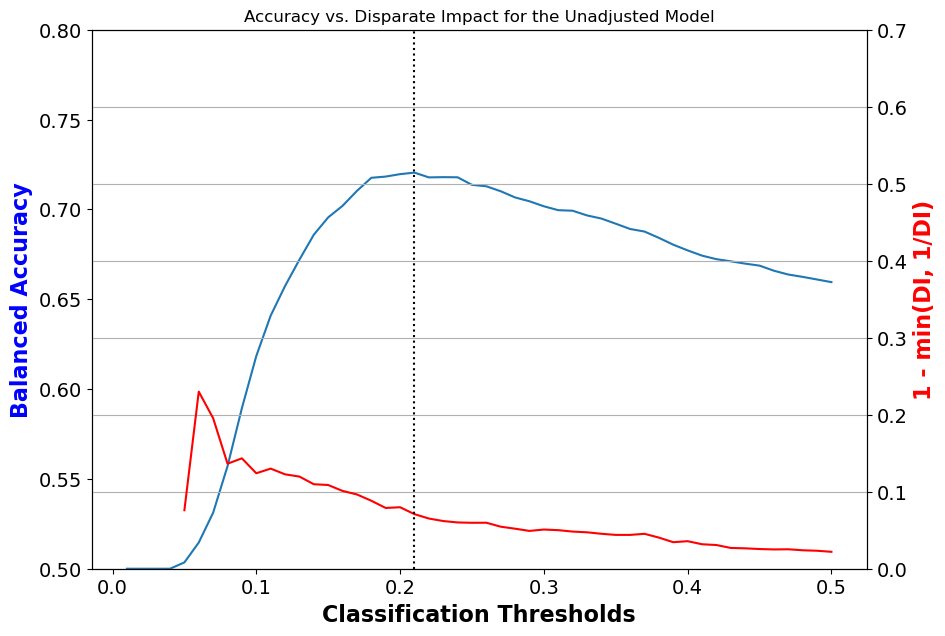

In [37]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)',
     "Accuracy vs. Disparate Impact for the Unadjusted Model")

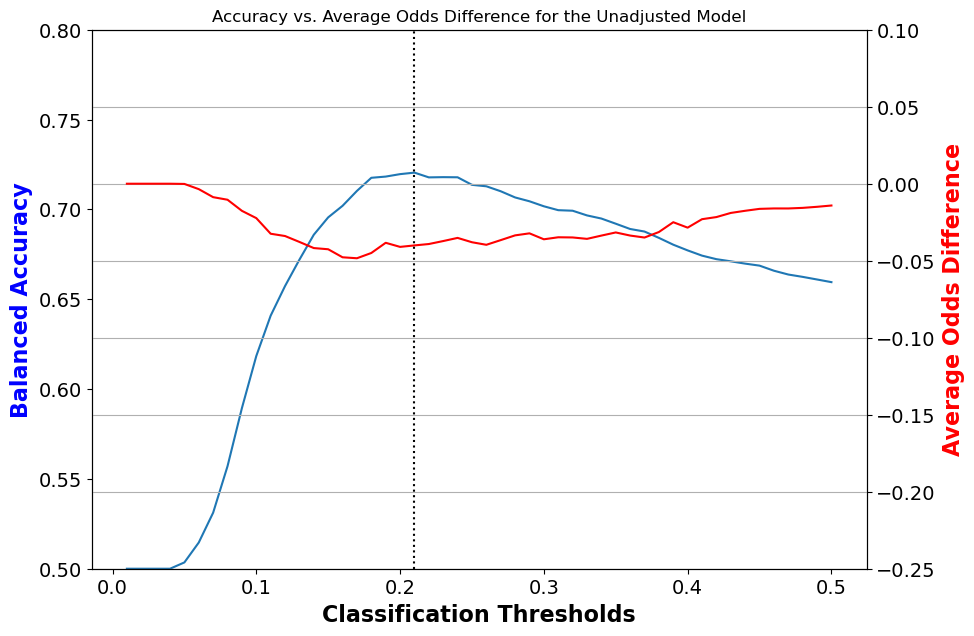

In [38]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics["avg_odds_diff"], 'Average Odds Difference',
     "Accuracy vs. Average Odds Difference for the Unadjusted Model")

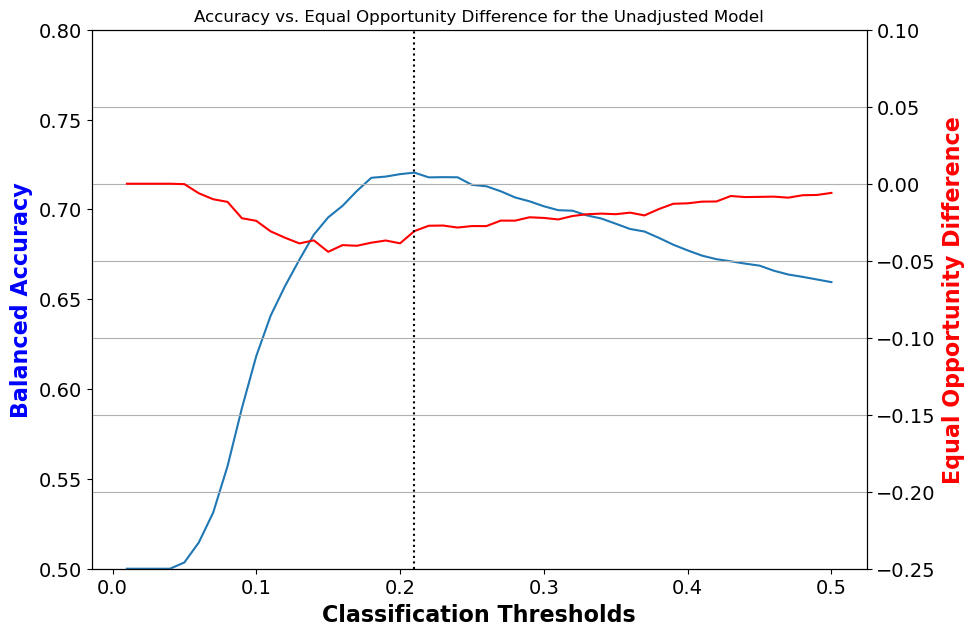

In [39]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics["eq_opp_diff"], 'Equal Opportunity Difference',
     "Accuracy vs. Equal Opportunity Difference for the Unadjusted Model")

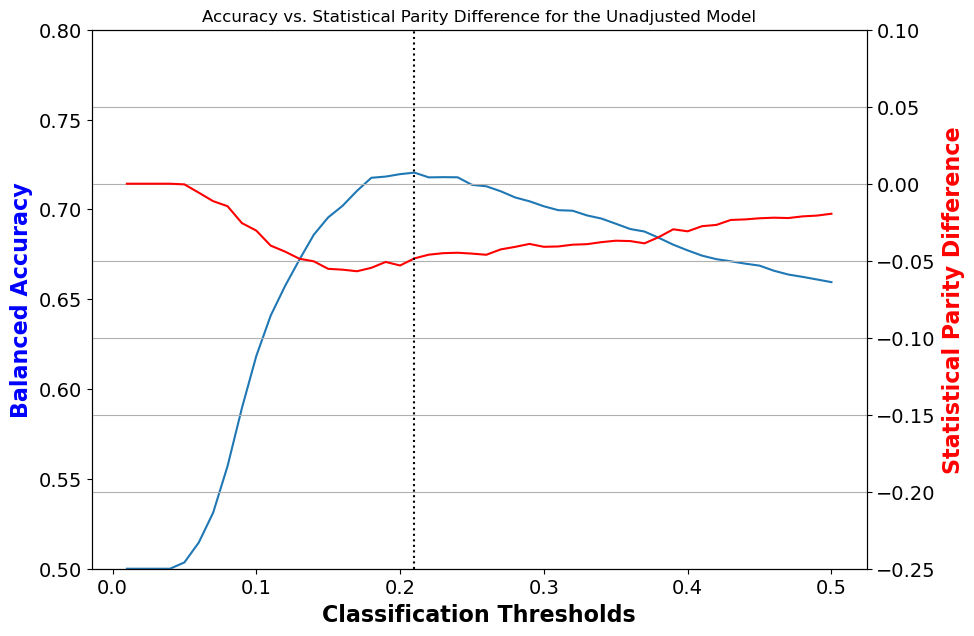

In [40]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics["stat_par_diff"], 'Statistical Parity Difference',
     "Accuracy vs. Statistical Parity Difference for the Unadjusted Model")

In [41]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [42]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.7205
Corresponding 1-min(DI, 1/DI) value: 0.0709
Corresponding average odds difference value: -0.0401
Corresponding statistical parity difference value: -0.0485
Corresponding equal opportunity difference value: -0.0307
Corresponding Theil index value: 0.2273


### Adjust the data through pre-processing - Reweighing

In [43]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
data_train_transformed = RW.fit_transform(data_train)

In [44]:
metric_transf_train= BinaryLabelDatasetMetric(
        data_train_transformed,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())
print(explainer_transf_train.statistical_parity_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 1.1102230246251565e-16


In [45]:
# Split into x and y
X_train_transf = data_train_transformed.convert_to_dataframe()[0].drop(columns = ["default"])
y_train_transf = data_train_transformed.convert_to_dataframe()[0]["default"]

### Building Another Random Forest Model

In [46]:
## Build model 
xgb_model = xgb.XGBClassifier(random_state = 2023)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}
fit_param = {"sample_weight":data_train_transformed.instance_weights}
random_search_transf = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter = 10, cv = 5, scoring="roc_auc")
random_search_transf.fit(X_train_transf, y_train_transf, **fit_param)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1595b7310>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1588fb890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156f15a90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x158bb1d50>},
                   scoring='roc_auc')

In [47]:
best_xgb_reweighted = random_search_transf.best_estimator_

In [48]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics_reweighted = test(dataset=data_test,
                   model=best_xgb_reweighted,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)
lr_reweighted_best_ind = np.argmax(val_metrics_reweighted['bal_acc'])

/Users/genesisqu/miniconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [49]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.7205
Corresponding 1-min(DI, 1/DI) value: 0.0709
Corresponding average odds difference value: -0.0401
Corresponding statistical parity difference value: -0.0485
Corresponding equal opportunity difference value: -0.0307
Corresponding Theil index value: 0.2273


In [50]:
describe_metrics(val_metrics_reweighted, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7127
Corresponding 1-min(DI, 1/DI) value: 0.0451
Corresponding average odds difference value: -0.0256
Corresponding statistical parity difference value: -0.0329
Corresponding equal opportunity difference value: -0.0150
Corresponding Theil index value: 0.1869


/var/folders/0d/23x0hjl172sgh7hhvyngkf9m0000gn/T/ipykernel_36293/2967843748.py:2: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err_rw = 1 - np.minimum(disp_imp, 1/disp_imp)


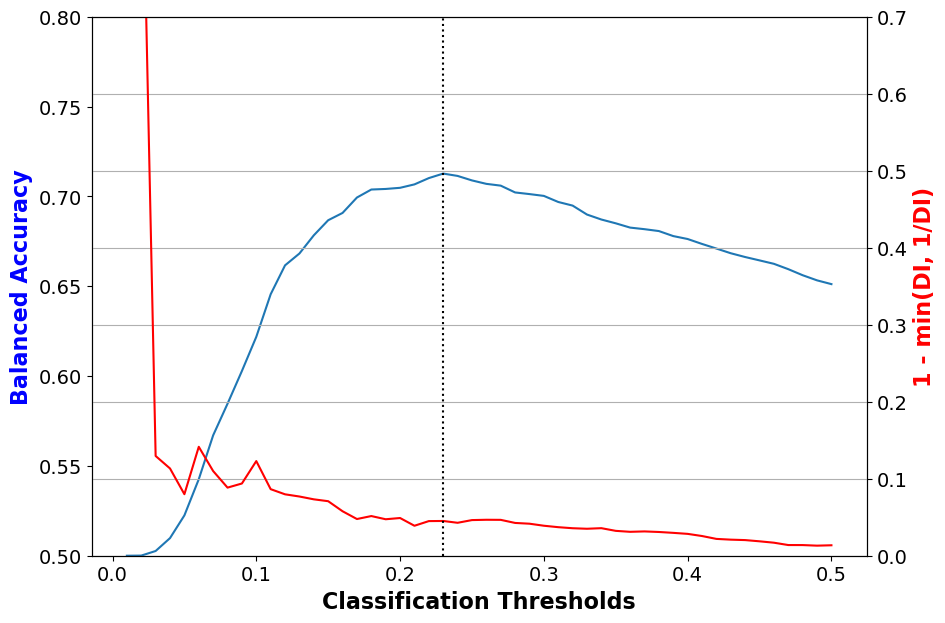

In [58]:
disp_imp_rw = np.array(val_metrics_reweighted['disp_imp'])
disp_imp_err_rw = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics_reweighted['bal_acc'], 'Balanced Accuracy',
     disp_imp_err_rw, '1 - min(DI, 1/DI)')

### Using Disparate Impact Remover

In [ ]:
di = DisparateImpactRemover(repair_level=1, sensitive_attribute="SEX")
train_repaired = di.fit_transform(data_train)

metric_repaired_train= BinaryLabelDatasetMetric(
        train_repaired,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_repaired_train = MetricTextExplainer(metric_repaired_train)

print(explainer_repaired_train.disparate_impact())
print(explainer_repaired_train.statistical_parity_difference())

X_train_repaired = train_repaired.convert_to_dataframe()[0].drop(columns = ["default"])
y_train_repaired = train_repaired.convert_to_dataframe()[0]["default"]

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0467919193613335
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.03527898909257998


In [ ]:
binary_data_mar = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df = data_dum,
    label_names = ["default"],
    protected_attribute_names = ["MARRIAGE_Single"],
)

# Set unpriviledged groups and priviledged groups
privileged_groups_mar = [{'MARRIAGE_Single': 1}]
unprivileged_groups_mar = [{'MARRIAGE_Single': 0}]

# Use the metric class in AIF360 to get the metric and explain it
metric_mar = BinaryLabelDatasetMetric(binary_data_mar, 
                                        unprivileged_groups=privileged_groups_mar,
                                        privileged_groups=unprivileged_groups_mar)
explainer_orig_mar = MetricTextExplainer(metric_mar)

# Print out disparate impact and mean_difference
print(explainer_orig_mar.disparate_impact())
print(explainer_orig_mar.mean_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8870962326607057
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.02680584587764165


### Plot comparison

In [74]:
def plot_compare(x, x_name, 
         y1_left, y1_left_name,
         y2_left, y2_left_name,  
         y1_right, y1_right_name,
         y2_right, y2_right_name, 
         title = None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    l1 = ax1.plot(x, y1_left, label = y1_left_name, color = "lightsteelblue",)
    l2 = ax1.plot(x, y2_left, label = y2_left_name, color = "tab:blue")
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y1_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    l3 = ax2.plot(x, y1_right, label = y1_right_name, color = "pink")
    l4 = ax2.plot(x, y2_right, label = y2_right_name, color = "tab:red")
    ax2.set_ylabel(y1_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y1_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind1 = np.argmax(y1_left)
    best_ind2 = np.argmax(y2_left)
    l5 = ax2.axvline(np.array(x)[best_ind1], color='lightsteelblue', linestyle=':', label = "Original Best")
    l6 = ax2.axvline(np.array(x)[best_ind2], color='tab:blue', linestyle=':', label = "Reweighted Best")
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    lines = l1+l2+l3+l4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center', 
               bbox_to_anchor=(0.5, -0.1),
               fancybox=True, shadow=True, ncol=2)
    if title is not None:
        ax1.set_title(title)

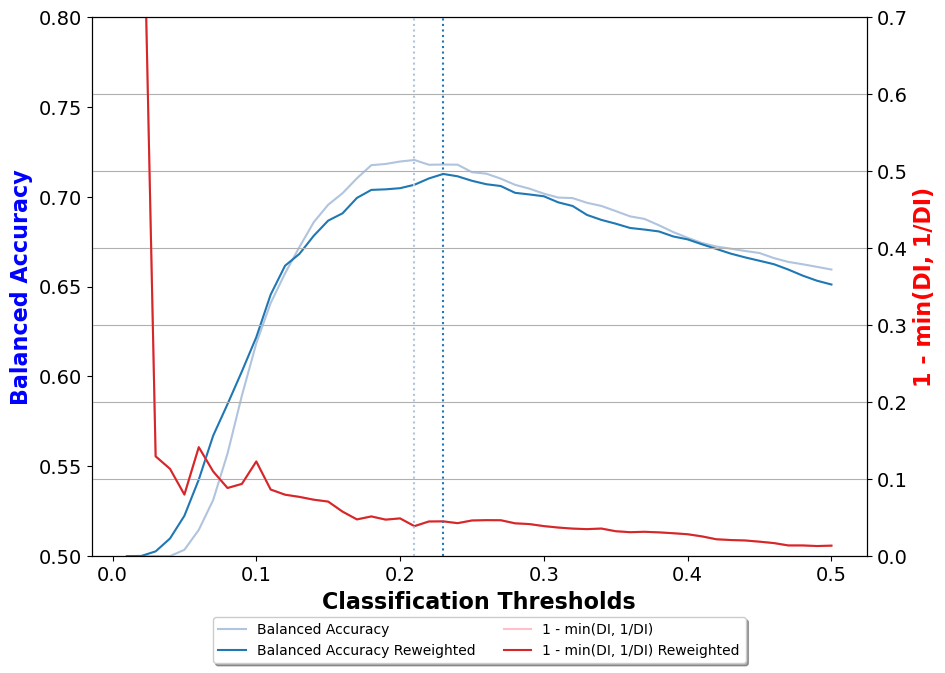

In [75]:
plot_compare(
    thresh_arr, 'Classification Thresholds',
    val_metrics['bal_acc'], 'Balanced Accuracy',
    val_metrics_reweighted['bal_acc'], 'Balanced Accuracy Reweighted',
    disp_imp_err, '1 - min(DI, 1/DI)',
    disp_imp_err_rw, '1 - min(DI, 1/DI) Reweighted'
)

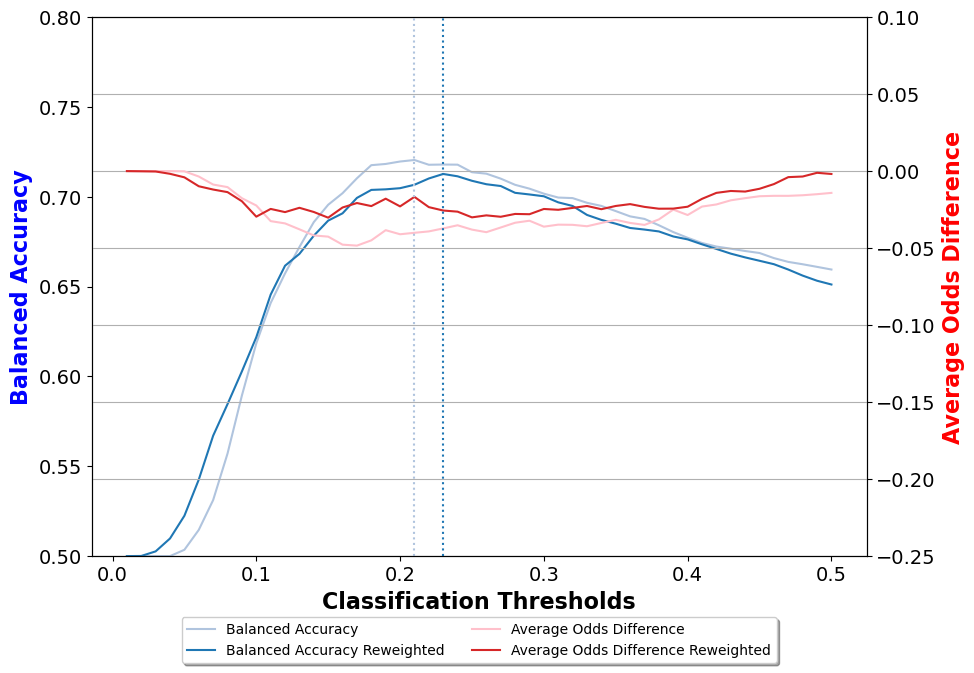

In [76]:
plot_compare(
    thresh_arr, 'Classification Thresholds',
    val_metrics['bal_acc'], 'Balanced Accuracy',
    val_metrics_reweighted['bal_acc'], 'Balanced Accuracy Reweighted',
    val_metrics["avg_odds_diff"], 'Average Odds Difference',
    val_metrics_reweighted["avg_odds_diff"], 'Average Odds Difference Reweighted'
)

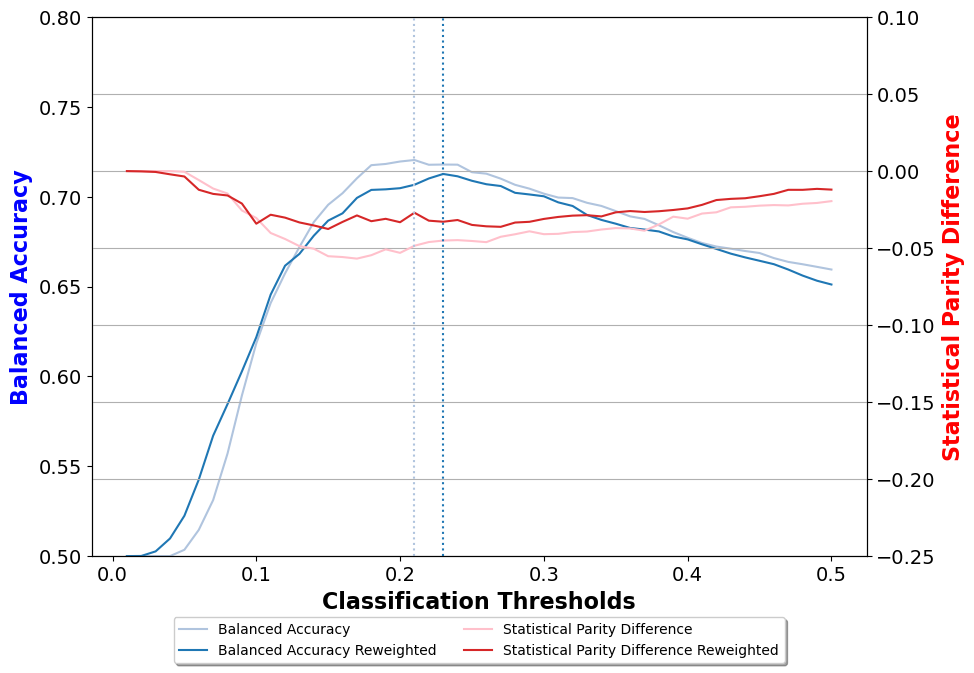

In [77]:
plot_compare(
    thresh_arr, 'Classification Thresholds',
    val_metrics['bal_acc'], 'Balanced Accuracy',
    val_metrics_reweighted['bal_acc'], 'Balanced Accuracy Reweighted',
    val_metrics["stat_par_diff"], 'Statistical Parity Difference',
    val_metrics_reweighted["stat_par_diff"], 'Statistical Parity Difference Reweighted'
)